# Handwritten Digit Classification using pure python/numpy
Elif Cansu YILDIZ

In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

## Dataset

In [2]:
train_dataset = datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(), download=True)

In [3]:
n_train_data = len(train_dataset)
n_test_data = len(test_dataset)

print("number of training data: ", n_train_data)
print("number of test data    : ", n_test_data)

number of training data:  60000
number of test data    :  10000


## Visualize Data

torch.Size([1, 1, 28, 28])


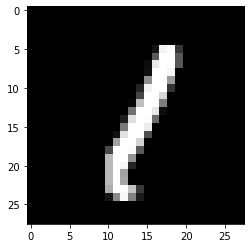

In [4]:
train_loader = th.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

for id, (img, label) in enumerate(train_loader):
    if id==1:
        print(img.shape)
        plt.figure()
        plt.imshow(img.reshape(28,28), cmap=plt.get_cmap('gray'))
        break

## Activation Functions

In [5]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [6]:
def one_hot(labels):
    y_onehot = np.zeros((labels.size, labels.max()+1))
    y_onehot[np.arange(labels.size),labels] = 1
    return y_onehot

## Dataset Preprocessing

In [7]:
train_dataloader = th.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
train_data = next(iter(train_dataloader))[0].numpy()
train_labels = next(iter(train_dataloader))[1].numpy()

test_dataloader = th.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
test_data = next(iter(test_dataloader))[0].numpy()
test_labels = next(iter(test_dataloader))[1].numpy()
#print("train_data.shape: {} test_data.shape: {} train_labels.shape: {} test_labels.shape: {}".format(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape))

########## DATA SHAPE MODIFICATION ############

train_data = train_data.reshape(-1, 28*28)
test_data = test_data.reshape(-1, 28*28)

train_labels = one_hot(train_labels)
test_labels = one_hot(test_labels)

print("train_data.shape: {} \ntest_data.shape: {} \ntrain_labels.shape: {} \ntest_labels.shape: {}".format(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape))

train_data.shape: (60000, 784) 
test_data.shape: (10000, 784) 
train_labels.shape: (60000, 10) 
test_labels.shape: (10000, 10)


## Loss Function

In [8]:
def MSE_loss(y, y_pred):
    return np.mean((y-y_pred)**2)

## Network Class

In [9]:
class Network:
    def __init__(self, input_size, output_size, lr):
        self.input_size = input_size
        self.output_size = output_size
        self.lr = lr
        
        self.params = {}
        self.num_hidden = 64
        self.w1 = np.random.random((self.input_size, self.num_hidden)) - 0.5     # w1.shape: (784, 64)
        self.w2 = np.random.random((self.num_hidden, self.output_size)) - 0.5    # w2.shape: (64, 10)
        self.params["w1"] = self.w1
        self.params["w2"] = self.w2
        
        #print("w1.shape: {} w2.shape: {}".format(self.w1.shape, self.w2.shape))
          
    def forward(self, x):
        
        out1 = self.w1.T @ x
        a1 = sigmoid(out1)
        
        out2 = self.w2.T @ a1
        a2 = softmax(out2)
        
        self.params["out1"] = out1
        self.params["a1"] = a1
        self.params["out2"] = out2
        self.params["a2"] = a2
        
        #print("a1.shape: {} y.shape: {}".format(a1.shape, a2.shape))
        
        return a2
    
    def step(self, Y, X):
        grads = derivative(self.params, Y, X)
        self.w1 = self.w1 - self.lr * grads["grad_w1"]
        self.w2 = self.w2 - self.lr * grads["grad_w2"]


In [10]:
model = Network(784, 10, lr=0.05)
out = model.forward(train_data[:4].T)

## Backpropagation

In [11]:
def softmax_derivative(Sz):
    samples = Sz.shape[0]
    features = Sz.shape[1]
    
    # Calculate outer part
    Sz_ = np.expand_dims(Sz, axis=-1)
    outer = np.einsum('ijk,imn->ijm', Sz_, Sz_) # (samples, features, features) # a fancy alternative to torch.bmm

    # Calculate diagonal part
    identity_single = np.identity(features)
    identity_multiple = np.transpose(np.dstack([identity_single]*samples), (2, 0, 1))
    diag = identity_multiple * Sz.reshape(samples, features, 1)

    return -outer + diag

In [12]:
def derivative(params, y_true, X):
    grads = {}
    
    back_error = (2/X.shape[1]) * (params["a2"]-y_true)   #2/N * (y-y_t)  #(10,20)
    
    back_a2 = np.einsum("aij,aj->ai", softmax_derivative(params["a2"].T), back_error.T).T    # (10,20)
    
    back_out2 = params["w2"] @ back_a2  # (64,20)
    back_a1 = params["a1"] * (1 - params["a1"]) * back_out2    #(64,20)
    grad_w1 = X @ back_a1.T   #(784, 64)
    
    grad_w2 = params["a1"] @ back_a2.T
    
    #print("grad_w1.shape: {}  grad_w2.shape: {}".format(grad_w1.shape, grad_w2.shape))
    
    #print("back_error: {} \nback_a2: {} \nback_out2: {} \nback_a1: {} \ngrad_w1: {} \ngrad_w2: {}".format(back_error, back_a2, back_out2, back_a1, grad_w1, grad_w2))
    
    grads["grad_w1"] = grad_w1
    grads["grad_w2"] = grad_w2
    
    return grads

In [13]:
model = Network(784, 10, lr=0.05)
out = model.forward(train_data[:4].T)
der_out = derivative(model.params, train_labels[:4].T, train_data[:4].T)
out.shape

(10, 4)

## Train and Evaluation Function

In [14]:
def train(model, train_X, train_Y, batch_size):
    
    loss = 0
    total_acc = 0
    num_batch = int(len(train_dataset)/batch_size)
    for idx in range(num_batch+1): 
        
        if idx == num_batch:
            continue   # drop the last minibatch
        else:
            batch_X = train_X[idx*batch_size : (idx+1)*batch_size, :].T
            batch_Y = train_Y[idx*batch_size : (idx+1)*batch_size, :].T
         
        # forward    
        y_pred = model.forward(batch_X)
        
        # loss calculation
        loss += MSE_loss(batch_Y, y_pred)
        
        # accuracy calculation
        pred_label = np.argmax(y_pred, axis=0)  #hardmax
        true_label = np.argmax(batch_Y, axis=0)
        acc = (np.sum(pred_label==true_label) / len(true_label))
        total_acc += acc
        
        # backward and update
        model.step(batch_Y, batch_X)
        
    return loss/num_batch, total_acc/num_batch

def evaluate(model, val_X,  val_Y, batch_size):
    
    loss = 0
    total_acc = 0
    num_batch = int(len(val_X)/batch_size)
    
    for idx in range(num_batch+1):
        
        if idx == num_batch:
            continue   # since last batch is empty
            batch_X = val_X[num_batch*batch_size : len(val_X), :].T
            batch_Y = val_Y[num_batch*batch_size : len(val_X), :].T
        
        else:
            batch_X = val_X[idx*batch_size : (idx+1)*batch_size, :].T
            batch_Y = val_Y[idx*batch_size : (idx+1)*batch_size, :].T
         
        # forward    
        y_pred = model.forward(batch_X)
        
        # loss calculation
        loss += MSE_loss(batch_Y, y_pred)
        
        # accuracy calculation
        pred_label = np.argmax(y_pred, axis=0)  #hardmax
        true_label = np.argmax(batch_Y, axis=0)
        acc = (np.sum(pred_label==true_label) / len(true_label))
        total_acc += acc
        
    return loss/num_batch, total_acc/num_batch

In [15]:
arr = np.random.random((4,6))
print(arr)
np.argmax(arr, axis=0)

[[0.50732553 0.76564741 0.14492035 0.83605328 0.06235725 0.92525051]
 [0.75277168 0.02736267 0.30808039 0.48470917 0.2016648  0.54672164]
 [0.84620174 0.01723391 0.65777373 0.54244784 0.67631718 0.99067507]
 [0.39354568 0.006742   0.0291351  0.61382994 0.22378024 0.4170993 ]]


array([2, 0, 2, 0, 2, 2])

## Main Function

In [16]:
epoch = 50
batch_size = 20
lr = 0.05

model = Network(input_size=784, output_size=10, lr=lr)
train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

for i in range(epoch):
    
    train_loss, train_acc = train(model, train_data, train_labels, batch_size)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    
    val_loss, val_acc = evaluate(model, test_data, test_labels, batch_size) # *10
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    
    if i%10==0 or i==epoch-1:
        print("epoch: {}".format(i))
        print("train loss: {:.4f} train acc: {:.4f}".format(train_loss, train_acc))
        print("val loss: {:.4f} val acc: {:.4f}".format(val_loss, val_acc))

epoch: 0
train loss: 0.0438 train acc: 0.7089
val loss: 0.0253 val acc: 0.8476
epoch: 10
train loss: 0.0115 train acc: 0.9262
val loss: 0.0112 val acc: 0.9274
epoch: 20
train loss: 0.0091 train acc: 0.9420
val loss: 0.0093 val acc: 0.9403
epoch: 30
train loss: 0.0077 train acc: 0.9511
val loss: 0.0083 val acc: 0.9454
epoch: 40
train loss: 0.0068 train acc: 0.9575
val loss: 0.0076 val acc: 0.9492
epoch: 49
train loss: 0.0062 train acc: 0.9617
val loss: 0.0072 val acc: 0.9525


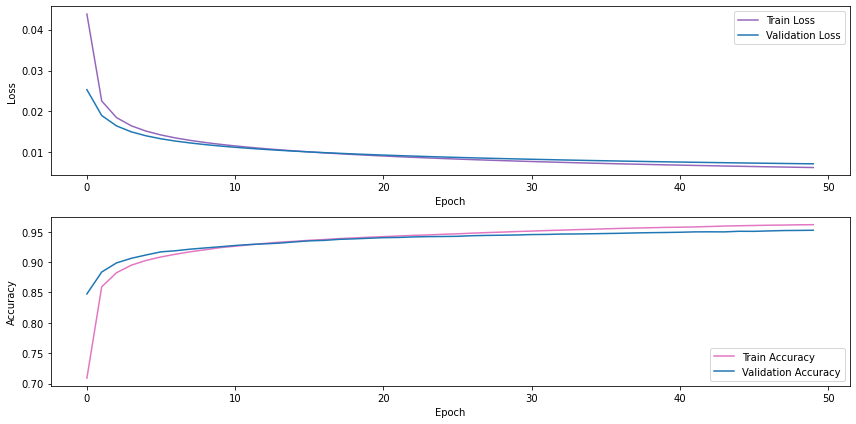

In [17]:
fig, (axs1, axs2) = plt.subplots(2, figsize=(12,6))
axs1.plot(train_loss_hist, "tab:purple", label="Train Loss")
axs1.plot(val_loss_hist, label="Validation Loss")
axs1.set_xlabel("Epoch")
axs1.set_ylabel("Loss")
axs1.legend()

axs2.plot(train_acc_hist, "tab:pink", label="Train Accuracy")
axs2.plot(val_acc_hist, label="Validation Accuracy")
axs2.set_xlabel("Epoch")
axs2.set_ylabel("Accuracy")
axs2.legend()

fig.tight_layout()